In [2]:
import pandas as pd
import ast

excel_path = '/home/uceehuf/ELEC0141_NLP/Dataset/Policy.xlsx'
# Loading policy from Excel
policy_df = pd.read_excel(excel_path,sheet_name= 0, engine='openpyxl')
prompt_df = pd.read_excel(excel_path,sheet_name= 1, engine='openpyxl')
label_df = pd.read_excel(excel_path,sheet_name= 2, engine='openpyxl')

policy_scripts = policy_df['Policy Scripts'].tolist()

In [3]:
def parse_labels(label_str):
    try:
        # Safely evaluate the string as a Python literal (list in this case)
        return ast.literal_eval(label_str)
    except ValueError:
        # In case of an error (e.g., malformed string), return an empty list or handle accordingly
        return []

# Apply the conversion to each row in the 'CorrectLabels' column
label_df['True'] = label_df['label list'].apply(parse_labels)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch

# Check if the GPU is available
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

0
NVIDIA A100 80GB PCIe


In [39]:
from transformers import DataCollatorWithPadding, AutoTokenizer, Trainer, TrainingArguments
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

torch_dtype = torch.float16
# Load tokenizer and model
# Mistral 7B it
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2",
    trust_remote_code=True, device_map="auto", torch_dtype=torch_dtype)
model.config.pad_token_id = model.config.eos_token_id

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


In [6]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Embedding vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(policy_scripts).toarray()

# option for refitting with new words
refit_flag = True

if(refit_flag == True):
    # Extract features from new docs
    new_features = TfidfVectorizer().fit(prompt_df['Prompt']).get_feature_names_out()

    # Combine the features
    combined_features = vectorizer.get_feature_names_out().tolist() + list(set(new_features) - set(vectorizer.get_feature_names_out()))

    # Create a new vectorizer with the updated vocabulary
    vectorizer = TfidfVectorizer(vocabulary=combined_features)
    vectorizer.fit((policy_scripts) + (prompt_df['Prompt']).tolist())  # Fit the updated vectorizer to new docs

    X = vectorizer.fit_transform(policy_scripts).toarray()

# Convert to float32 for FAISS compatibility
X = np.array(X, dtype='float32')

print(X[5])

[0. 0. 0. ... 0. 0. 0.]


In [7]:
import faiss

# initialise with the dimension of the vectors
d = X.shape[1]

# Add index
index = faiss.IndexFlatL2(d)
index.add(X)

In [8]:

def evaluate_retrieval(search_result, true_labels):
    """
    Check if all true labels are contained within the predicted labels.
    Args:
    predicted_labels (list): The labels retrieved by the search model.
    true_labels (list): The correct labels listed in the Excel file.

    Returns:
    bool: True if all true labels are in the predicted labels, False otherwise.
    """
    #force the input to be sets;
    y_pred = set(search_result)
    y_true = set(true_labels)

    # check coverage
    correct = y_true.intersection(y_pred)
    
    # Calculate coverage
    coverage = len(correct) / len(y_true)

    # note missed labels
    misses = list(y_true - y_pred)

    return y_true.issubset(y_pred), coverage, misses


In [9]:
global default_files
default_files = False

def k_top_search(upper_thres, vectorizer, index, prompt_df, label_df, lower_thres = 5):
    """
    loop through all k in a range, from lower thres (5 by default) to upper thres,
    giving a figure showing the accuracy, coverage and average token number over different k
    Args:
    upper_thres (int): Number of top searches upper limit
    lower_thres (int): Number of top searches lower limit
    vectorizer: Tfidvectorizer, fitted
    index: faiss object after index addition
    prompt_df: pd df, must contain 'Prompt' column for queries
    label_df: pd df, must contain 'True' column for true labels
    Returns:
    null
    """
    # lists for plots
    accuracies = []
    coverages = []
    num_tokens = []

    for k in range(lower_thres, upper_thres+1):
        indices_list = []
        missed_list = []

        RAGed_prompt = []

        token_count = 0

        for query in prompt_df['Prompt']:

            query_vector = vectorizer.transform([query]).toarray()
            query_vector = np.array(query_vector, dtype='float32')
            _, indices = index.search(query_vector, k)

            # implement default file augment
            temp_q = indices.flatten().tolist()


            if default_files == True:
                for element in [0,44]:
                    if element not in temp_q:
                        temp_q.append(element)

            indices_list.append(temp_q)

            # combining the full query with full searched docs
            combined_query = query
            for temp in temp_q:
                combined_query = combined_query + ' ' + policy_scripts[temp]

            RAGed_prompt.append(combined_query)
            # tokenize
            tokens = tokenizer.tokenize(combined_query)
            
            # Return the number of tokens
            token_count += len(tokens)

        # Adding search results for further check
        prompt_df['TopIndices'] = indices_list
        prompt_df['RAGed prompt'] = RAGed_prompt

        #evaluate
        accu_count = 0
        accu_cover_count = 0
        for i in range(len(prompt_df)):
            temp, cover, missed = evaluate_retrieval(prompt_df['TopIndices'][i] , label_df['True'][i])

            accu_count += int(temp)
            accu_cover_count += cover

            missed_list.append(missed)

        accuracy_1 = accu_count/len(prompt_df)
        coverage_1 = accu_cover_count/len(prompt_df)
        print(f"For top {k} searches:\nAccuracy of search results containing all correct labels: {accuracy_1 * 100},\n Average coverage of correct labels: {coverage_1 * 100}")

        token_1 = token_count/len(prompt_df)
        print(f"Average tokens combining the query and retrieved docs: {token_1}")

        # Add to the lists
        accuracies.append(accuracy_1)
        coverages.append(coverage_1)
        num_tokens.append(token_1)
        
    return accuracies, coverages, num_tokens, missed_list


In [10]:
upper_search = 20
a,b,c, last_missed_list = k_top_search(upper_thres= upper_search,vectorizer = vectorizer, index = index, prompt_df = prompt_df, label_df = label_df)

For top 5 searches:
Accuracy of search results containing all correct labels: 27.500000000000004,
 Average coverage of correct labels: 69.79166666666667
Average tokens combining the query and retrieved docs: 1952.925
For top 6 searches:
Accuracy of search results containing all correct labels: 33.0,
 Average coverage of correct labels: 74.59166666666663
Average tokens combining the query and retrieved docs: 2260.83
For top 7 searches:
Accuracy of search results containing all correct labels: 40.5,
 Average coverage of correct labels: 78.34166666666661
Average tokens combining the query and retrieved docs: 2525.23
For top 8 searches:
Accuracy of search results containing all correct labels: 47.5,
 Average coverage of correct labels: 81.19166666666663
Average tokens combining the query and retrieved docs: 2780.31
For top 9 searches:
Accuracy of search results containing all correct labels: 52.0,
 Average coverage of correct labels: 83.34166666666664
Average tokens combining the query and

In [11]:
missed_df = pd.DataFrame({'Missed_Labels':last_missed_list})

# Flatten the lists of missed labels into a single list
missed_labels = [label for sublist in missed_df['Missed_Labels'] for label in sublist]

# Calculate frequency counts of missed labels
missed_labels_counts = pd.Series(missed_labels).value_counts().to_dict()

# Print the frequency counts
print("Missed labels and their frequencies:")
for label, count in missed_labels_counts.items():
    print(f"{label}: {count}")

Missed labels and their frequencies:
33: 10
45: 9
32: 5
37: 4
12: 3
23: 3
5: 2
31: 2
44: 1
46: 1
10: 1
11: 1
34: 1


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
miss = pd.DataFrame.from_dict(missed_labels_counts, orient='index', columns=['Value'])

# Plot the bar chart
miss.plot(kind='bar', legend=None)
plt.xlabel('Missed Index Label')
plt.xticks(rotation=45)
plt.ylabel('Missed Frequency')
plt.title('TF-IDF Model RAG Missed Indices Counts')
plt.savefig('../images/TF-IDF_miss.png')
plt.show()

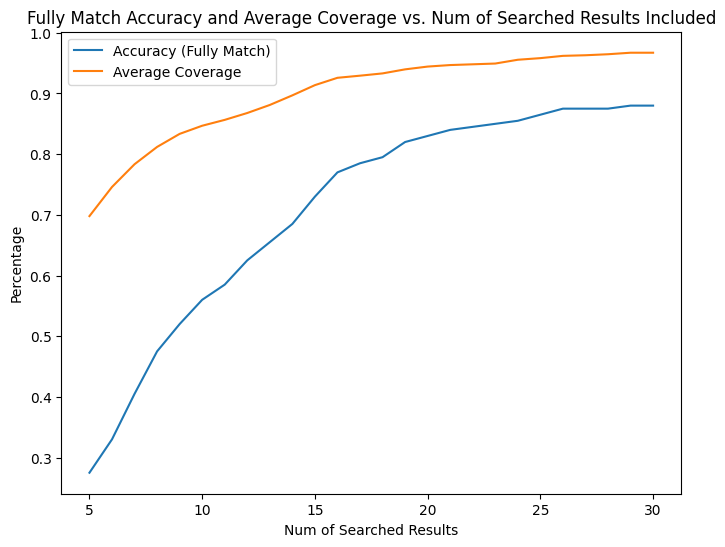

In [ ]:


# Plot acc and cover.
plt.figure(figsize=(8, 6))
plt.plot(range(5, upper_search+1), a, label='Accuracy (Fully Match)')
plt.plot(range(5, upper_search+1), b, label='Average Coverage')
plt.xlabel('Num of Searched Results')
plt.ylabel('Percentage')
plt.title('Fully Match Accuracy and Average Coverage vs. Num of Searched Results Included')
plt.legend()
plt.savefig('../images/acc_1.png')  # Save the plot
#plt.close()  # Close the figure to release memory


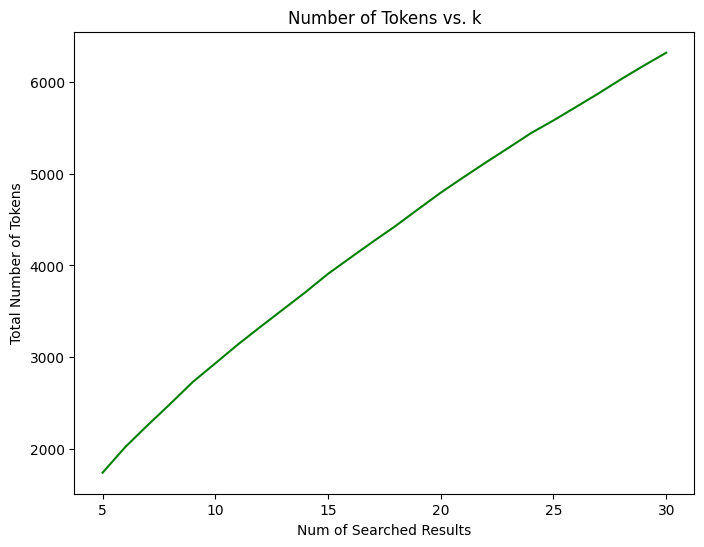

In [ ]:

# Plot number of tokens
plt.figure(figsize=(8, 6))
plt.plot(range(5, upper_search+1), c, color='green')
plt.xlabel('Num of Searched Results')
plt.ylabel('Total Number of Tokens')
plt.title('Number of Tokens vs. k')
plt.savefig('../images/num_tokens_1.png')  # Save the plot to a specific path
#plt.close()  # Close the figure to release memory

In [ ]:
indices_list = []
token_count = 0
for query in prompt_df['Prompt']:

    query_vector = vectorizer.transform([query]).toarray()
    query_vector = np.array(query_vector, dtype='float32')
    _, indices = index.search(query_vector, 6)
    indices_list.append(indices.flatten().tolist())

    combined_query = query
    for temp in indices.flatten().tolist():
        combined_query = combined_query + ' ' + policy_scripts[temp]

    # tokenize
    tokens = tokenizer.tokenize(combined_query)
    
    # Return the number of tokens
    token_count += len(tokens)

# Adding search results for further check
prompt_df['Top3Indices'] = indices_list


In [ ]:
# Save to new sheet, only run once
with pd.ExcelWriter(excel_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    prompt_df[['Prompt','Top3Indices']].to_excel(writer, sheet_name='Eval_result1')


In [ ]:
# restart the loop, with default file selection built in
default_files = True
a_new,b_new,c_new, last_missed_list = k_top_search(upper_thres= upper_search,vectorizer = vectorizer, index = index, prompt_df = prompt_df, label_df = label_df)

For top 5 searches:
Accuracy of search results containing all correct labels: 54.50000000000001,
 Average coverage of correct labels: 84.25
Average tokens combining the query and retrieved docs: 2163.885
For top 6 searches:
Accuracy of search results containing all correct labels: 59.0,
 Average coverage of correct labels: 85.89166666666667
Average tokens combining the query and retrieved docs: 2344.85
For top 7 searches:
Accuracy of search results containing all correct labels: 62.0,
 Average coverage of correct labels: 86.92499999999998
Average tokens combining the query and retrieved docs: 2514.74
For top 8 searches:
Accuracy of search results containing all correct labels: 63.5,
 Average coverage of correct labels: 87.525
Average tokens combining the query and retrieved docs: 2692.235
For top 9 searches:
Accuracy of search results containing all correct labels: 66.5,
 Average coverage of correct labels: 88.39166666666667
Average tokens combining the query and retrieved docs: 2890.4

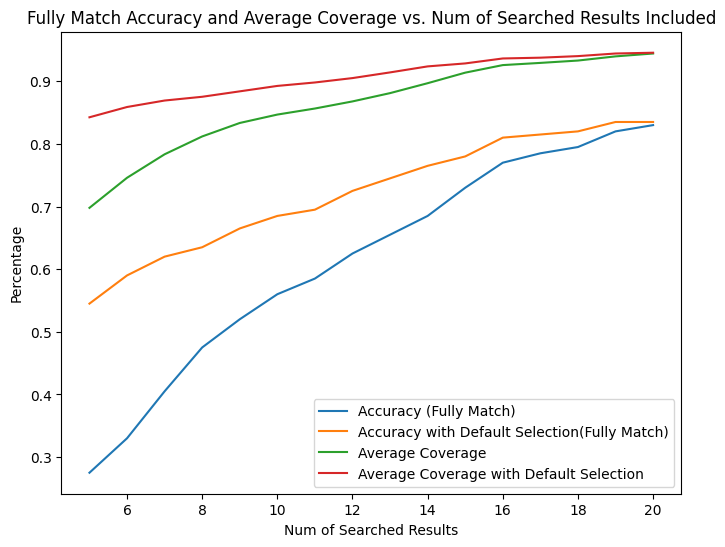

In [ ]:
import matplotlib.pyplot as plt

# Plot acc and cover.
plt.figure(figsize=(8, 6))
plt.plot(range(5, upper_search+1), a, label='Accuracy (Fully Match)')
plt.plot(range(5, upper_search+1), a_new, label='Accuracy with Default Selection(Fully Match)')
plt.plot(range(5, upper_search+1), b, label='Average Coverage')
plt.plot(range(5, upper_search+1), b_new, label='Average Coverage with Default Selection')
plt.xlabel('Num of Searched Results')
plt.ylabel('Percentage')
plt.title('Fully Match Accuracy and Average Coverage vs. Num of Searched Results Included')
plt.legend()
plt.savefig('../images/acc_1.png')  # Save the plot to a specific path
#plt.close()  # Close the figure to release memory


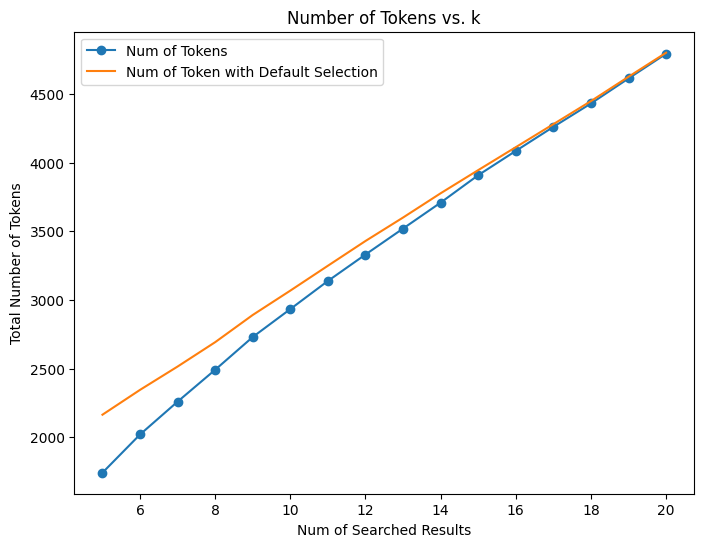

In [ ]:
# Plot number of tokens
plt.figure(figsize=(8, 6))
plt.plot(range(5, upper_search+1), c,marker = 'o', label='Num of Tokens')
plt.plot(range(5, upper_search+1),  c_new, label='Num of Token with Default Selection')
plt.xlabel('Num of Searched Results')
plt.ylabel('Total Number of Tokens')
plt.title('Number of Tokens vs. k')
plt.legend()
plt.savefig('../images/num_tokens_1.png')  # Save the plot to a specific path
#plt.close()  # Close the figure to release memory

In [ ]:
# pack data for plot in other .ipynb file
result_pd = pd.DataFrame(a, columns = ['acc'])

result_pd = pd.concat([result_pd, pd.DataFrame(a_new, columns = ['acc_new']),
                       pd.DataFrame(b, columns = ['cov']),
                       pd.DataFrame(b_new, columns = ['cov_new']),
                       pd.DataFrame(c, columns = ['token']),
                       pd.DataFrame(c_new, columns = ['token_new']),], axis = 1)
result_pd.index += 5
result_pd.to_csv('../Dataset/data_tfidf.csv', index=False)

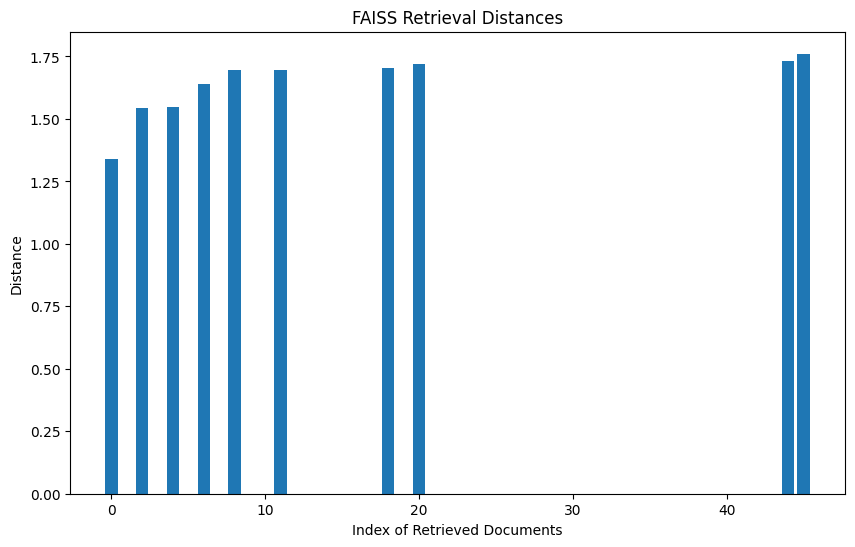


### Document 4:
Travel Insurance
Travel Insurance needs to be activated before traveling overseas, travelling in the UK for fieldtrips or travelling on a business trip where there is an overnight stay or air travel involved.
Insurance can be activated by completing a travel insurance request form, which can be found in the Insurance Section on the Finance website.
The Insurance team will issue a cover note and provide details of the policy. There is no cost to departments for travel insurance. For regular travellers the Insurance Section can issue annual cover notes on request.
If a claimant has an existing medical condition and is not travelling against their doctors’ orders, this is covered by the GNEI Travel Insurance Policy at no extra cost.
Personal travel insurance cannot be claimed as GNEI already provides cover for business travel, please refer to Annex 2 for further information on this exclusion.

### Document 18:
Group Travel
This is in relation to a staff conference or stud

In [ ]:
import matplotlib.pyplot as plt

# Retrieve and plot the distances
plt.figure(figsize=(10, 6))
plt.bar(np.sort(indices[0]), distances[0])
plt.title('FAISS Retrieval Distances')
plt.xlabel('Index of Retrieved Documents')
plt.ylabel('Distance')
plt.show()

# Print the actual documents
for idx in indices[0]:
    print(f"\n### Document {idx}:\n{policy_scripts[idx]}" )


In [64]:
file_path = '../datasets/Train_Data.xlsx'
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
test_frame = pd.read_excel(file_path,sheet_name=2, engine='openpyxl')

data_test = test_frame#[test_frame["Category"] == "Accomodation and Sustenance"]
data_test.reset_index(drop=True, inplace=True)

In [59]:
def policy_RAG(prompt, k = 20):
    """
    retrieve relative k scripts according to the prompt and format them as policy context
    prompt:         str
    k:              int
    """
    print(prompt)
    query_vector = vectorizer.transform([prompt]).toarray()
    query_vector = np.array(query_vector, dtype='float32')
    _, indices = index.search(query_vector, k)

    # implement default file augment
    temp_q = indices.flatten().tolist()
    if default_files == True:
        for element in [0,44]:
            if element not in temp_q:
                temp_q.append(element)

    indices = temp_q

    # combining the full query with full searched docs
    combined_query = prompt
    for temp in indices:
        combined_query = combined_query + '\n' + policy_scripts[temp]

    #print(indices)

    return combined_query

def get_responses(prompt_num, data_frame):
    """
        prompt_num: int: how many data points in data_frame involved
        data_frame: pdDataframe: provides a "Prompt" column containing scenarios
        # context:    str: the policy script to be included in the prompt

        return:
        pdDataframe: model_original_resp: a df containing trimmed responses in a column manner
        """
    model_original_resp = []
    for i in range(prompt_num):
        # iterating through all data points
 
        # RAG the policy
        context = policy_RAG(data_frame['Prompt'][i], k = 15)
        #print(context)

        prompt = f"""A <<<POLICY>>> and a <<<SCENARIO>>> will be provided, you are GREAT at analysing the <<<SCENARIO>>> according to the <<<POLICY>>>. Your answer MUST and and CAN ONLY be a valid json format, having 4 text fields: Classification T1, Reimbursement Amount, Classification T2, and Reasons. Your answer should follow these structures: \n 1) "Classification T1" :you MUST choose 'Policy Violated' or 'Policy Not Violated' for the activity in the <<<scenario>>> \n \n 2) "Reimbursement Amount" : Answer One number directly that according to the Policy the total amount of money can be reimbursed \n 3) "Classification T2" : Compare to the requested reimbursement amount in the scenario, and answer if the claim is 'Fully Reimbursable'/'Partially Reimbursable'/'Not Reimbursable'/'Further Clarification Required'. \n 4) give reasons for your choices according to the <<<POLICY>>>.\n\n

        <<<<<start examples:

        <<<<<example one:
        scenario: I used a TFL travel card to travel from home to the GNEI work station every day for a week and it cost me £50. How much can I reimburse?

        Answer:{{"Classification T1" : "Policy Violated",
                "Reimbursement Amount" : £0,
                "Classification T2" : "Not Reimbursable",
                "Reasons":"According to the GNEI Expenses Policy, travel between home and normal place of work (i.e., the GNEI campus) cannot be claimed. Thus, this expense cannot be reimbursed."}};

        <<<<<example two:
        scenario: I booked a taxi from the GNEI work station to my home yesterday night. The total cost was £25. I left the campus at 11:30pm. Can I expense this charge?

        Answer:{{"Classification T1" : "Policy Not Violated",
                "Reimbursement Amount" : £25,
                "Classification T2" : "Fully Reimbursable",
                "Reasons":"The GNEI Expenses Policy states that taxi fares can be claimed for journeys where a member of staff is working in the office very late, specifically after 11pm​​. Therefore, your taxi fare under these circumstances falls within the allowable expenses according to the policy, and total reimbursable amount is £25."}};
        
        <<<<<example three:
        scenario: I booked a taxi from the GNEI campus to my home yesterday night. The total cost was £35. I left the campus at 9:30pm. Can I expense this charge?

        Answer:{{"Classification T1" : "Policy Violated",
                "Reimbursement Amount" : £0,
                "Classification T2" : "Further Clarification Required",
                "Reasons":"Based on the GNEI Expenses Policy, taxi fares can only be claimed for specific reasons, such as if a member of staff is working in the office very late, specifically mentioned as after 11pm. Since you left the campus at 9:30pm, your taxi fare does not meet the criteria set out under the "Taxis" section for allowable taxi expenses.
                Therefore, based on the information provided in the GNEI Expenses Policy, you cannot expense the £35 taxi charge for a trip from the GNEI campus to your home that occurred at 9:30pm."}};
        
        <<<<<example four:
        scenario: I drove to Cambridge for a business trip along with another GNEI colleagues. The total distance covered was 60 miles. I accidentally hit the sidewalk and damaged the side of the car. The total cost of the repairs was £100. How much can I claim in expenses?  

        Answer:{{"Classification T1" : "Policy Violated",
                "Reimbursement Amount" : £30,
                "Classification T2" : "Partially Reimbursable",
                "Reasons":"For your business trip to Cambridge, driving a car for a total distance of 60 miles with another GNEI colleagues, you can claim expenses based on the GNEI Expenses Policy as follows:
                - **Mileage Claim**: According to section **4.32**, mileage for cars is reimbursed at a rate of 50p per mile for the first 11,000 miles in a tax year. Therefore, for 65 miles, the claim would be 60 miles x £0.50/mile = £30.
                - **Damage to the Vehicle**: Section **4.34** specifies that GNEI will not be held liable for damage or repairs to the vehicle used on GNEI’s business. Thus, the cost of repairs due to the accident, totaling £100, cannot be claimed under the policy.
                **Documentation and Approvals Required:**
                1. **Mileage Documentation**: Include details such as the start and end points of the journey, the purpose of the business trip, and the total number of miles claimed.
                2. **Approval for Business Travel**: Ensure that the business trip was pre-approved as per GNEI's travel policy requirements.
                3. **Vehicle Damage**: Since the policy excludes claims for vehicle damage or repairs, there is no requirement for documentation or approval in this context.

                **Total Amount That Can Be Expensed: £30** (for mileage only, as vehicle repair costs are not covered)."}};

        examples End>>>>>

        <<<<<Policy Start:{context}
        \n\n\nPolicy End>>>>>\n\n<<<<<Scenario Start:\n\n{data_frame['Prompt'][i]}\n\nScenario End>>>>>"""
        
        input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
        # input = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
        # print("tokenization completed",input_ids['input_ids'].shape)

        #get "Answer" token ID in the tokenizer, forcing the model to start answering with "Answer" and thus give a json output
        start_token_id = tokenizer.convert_tokens_to_ids("Answer")
       
        outputs = model.generate(**input_ids,max_new_tokens = 400, min_new_tokens = 5,
                                 #do_sample = False, temperature = 5, top_k = 0.9, 
                                 repetition_penalty = 1.2,
                                 forced_bos_token_id = start_token_id) # alter max number of tokens here
        
        # trim the output by removing prompt
        model_response = tokenizer.decode(outputs[0])

        trimmed_output = model_response[len(prompt)+5:]

        # collecting responses
        model_original_resp.append(trimmed_output)

        if ((i+1)%10 == 0):
                print(f"the",(i+1),"th prompt responded")
        #print(f"the",(i+1),"th prompt responded")
    return model_original_resp


In [65]:
prompt_num = len(data_test)
composed_resp = []
for i in range(1):
    model_original_resp = get_responses(prompt_num, data_test)    
    composed_resp.extend(model_original_resp)

df_original_resp = pd.DataFrame(composed_resp, columns=['original response'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I used a TFL travel card to travel from home to the GNEI campus every day for 2 weeks and it cost me £60. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled from London to Amsterdam for a conference on behalf of GNEI for which I the flight tickets cost me £80. Additionally, during this transaction, the bank also charged me £15 for the exchange rate. How much can be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I booked a taxi from the GNEI campus to my home yesterday night. The total cost was £30. I left the campus at 11:15pm. Can I expense this charge?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I booked a taxi from the GNEI campus to my home yesterday night. The total cost was £30. I left the campus at 9:00pm. Can I expense this charge?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I traveled to the GNEI campus to pick up some sensors from the lab and had to pay 15 pounds for the parking fee. Can I expense this?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Does GNEI provide travel insurance?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While on a business trip in Oslo, I used a train for a return journey from the airport to the city centre. The total cost of this was £20. Can this be claimed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While on a business trip to Oslo, I used a train for a return journey from the airport to the city centre. I travelled via first class. The total cost of this was £40. Can this be claimed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While on a business trip to Oslo, I used a train for a return journey from the airport to the city centre. I travelled via first class. The total cost of this was £40. I booked these tickets in advance and have an approval from the PS Head of Finance. Can this be claimed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While on a business trip in Oslo, I used a train for a return journey from the airport to the city centre.  I travelled with my wife. The tickets cost £20 each. Can this be claimed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 10 th prompt responded
In order to travel to Canada for work, I have to apply for a visa. The total cost of the visa application is £120. Additionally, I need to apply vaccinations as well, which cost £30 more. Can these be claimed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I hired a car for 3 days while on a business trip to Scotland. The total cost of the car hire was £150. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I hired a car for 3 days while on a business trip to Scotland. The total cost of the car hire was £150. I also had to purchase petrol worth £60 for this journey. I do not have the VAT receipt for the petrol expense. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While travelling to Wales for a business trip, I had to pay a total of £17 of toll charges. Can these be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In order to drop some sensors to the GNEI lab, I had to drive in to London on Tuesday. Because of this, I had to pay the congestion charge of £12.50. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I had to drive in to London on Tuesday. Because of this, I had to pay the congestion charge of £12.50. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I drove to Winchester for a business trip along with 2 other GNEI colleagues. The total distance covered was 65 miles. How much can I claim in expenses?  


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I drove my bike to Winchester for a business trip along with 1 other GNEI colleagues. The total distance covered was 65 miles. How much can I claim in expenses?  


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While driving my car on a business trip, I accidentally hit the sidewalk and damaged the side of the car. The total cost of the repairs was £100. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I drove to Winchester for a business trip along with 2 other GNEI colleagues. The total distance covered was 65 miles. I accidentally hit the sidewalk and damaged the side of the car. The total cost of the repairs was £100. How much can I claim in expenses?  


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 20 th prompt responded
While on a business trip, I travelled from my hotel to a restaurant for dinner. The cost of this journey was £8. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I took a 2 hour flight to Amsterdam for work purposes. The total cost of the flight was £50. I booked an economy ticket. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I took a 2 hour flight to Amsterdam for work purposes. The total cost of the flight was £90. I booked an business class ticket. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I took a 2 hour flight to Amsterdam for work purposes with my wife. The tickets cost £50 each. I booked an economy ticket. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I took a flexible flight to Amsterdam last week. The flight cost £70. Can I expense this?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I booked a hotel close to the GNEI campus. I was there for 5 days, and the total cost was £800. Can I expense this? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I normally work at the Cambridge GNEI campus. I travelled to the London GNEI campus for a work trip and had to book a hotel for 5 nights for this trip. The total hotel costs were £1000. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I normally work at the Cambridge GNEI campus. I travelled to the London GNEI campus for a work trip and had to book a hotel for 5 nights for this trip. The total hotel costs were £1500. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have to travel to Geneva for a work trip for 4 nights. The total cost of the hotel will be £800. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for a business purposes, and had to stay in a hotel for 3 nights. Breakfast was not included at the hotel. I spent £10 for breakfast each morning. I have the receipts for each expense. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 30 th prompt responded
I travelled to Wales for a business purposes, and had to stay in a hotel for 3 nights. Breakfast was not included at the hotel. I spent £5 for breakfast each morning. I do not have the receipts for any expense. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for a business purposes, and had to stay in a hotel for 3 nights. Breakfast was not included at the hotel. I spent £10 for breakfast each morning. I do not have the receipts for any expense. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for a business purposes, and had to stay in a hotel for 3 nights. Breakfast was included at the hotel. I spent £10 for breakfast each morning. I have the receipts for each expense. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for work and stayed there for 3 nights. I had dinner outside each night. The dinner costs were £21, £15, £17. I do not have the receipts. How much can I claim? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for work and stayed there for 3 nights. I had dinner outside each night. The dinner costs were £21, £15, £17. I do have the receipts. How much can I claim? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Wales for a work trip for 2 nights. I stayed at a hotel where the breakfast was not included. On the first day, I spent £10 on lunch and £20 on dinner. On the second day, I spent $8 on breakfast, £12 on lunch, and £25 on dinner. On the third day, I spent £9 on breakfast. How much can I claim in expenses?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I will be travelling to Wales for work for 3 months. Can I rent an accommodation and expense it? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Amsterdam for a conference. I stayed there for 1 day, i.e., arrived in the morning and left in the night. I was not able to get the receipts for my meals, but I had lunch for £8 and dinner for £15. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I will be travelling to Wales for work for 8 months. I will be renting a property, but it will not be rented under my name. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I will be staying in Wales for 8 months for work related reasons. I will be renting a property there, for which the rent will be £900 per month. In addition to this, the monthly council tax will be £50 and the utility bills are going to be £250. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 40 th prompt responded
For an overseas business trip, I stayed at a 5-star hotel in Berlin for 3 nights. The total cost was £900. How much can I reimburse for this? I have all the receipts from this expense. 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For an overseas business trip, I stayed at a 4-star hotel in Berlin for 3 nights. The total cost was £900. How much can I reimburse for this? I have all the receipts from this expense. 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For an overseas business trip, I stayed at a 3-star hotel in Berlin for 3 nights. The total cost was £600. How much can I reimburse for this? I have all the receipts from this expense. 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For an overseas business trip, I stayed at a 3-star hotel in Berlin for 3 nights. The total cost was £600. How much can I reimburse for this? I have all the receipts from this expense and also have an approval email for booking the hotel. 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For a business trip I stayed at a hotel for 3 nights. I had to use the gym at the hotel, which cost me £10 per day. How much can I expense? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I normally work at the Cambridge GNEI campus. I travelled to the London GNEI campus for a work trip and had to book a hotel for 5 nights for this trip. The total hotel costs were £1000. At the hotel, I also used the gym, which cost me £50 every day. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


When on a business trip to Netherlands, I bought a temporary sim card for work related calls within the country. The total cost of this was £10. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I stayed in a hotel for 3 nights in Wales for a work related trip. I had formal clothes with me for a conference which I had to attend, but during transit, food got spilt on them and I had to get them laundered. The cost of laundry was only £10. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I stayed in a hotel for 6 nights in Wales for a work related trip. I had formal clothes with me for a conference which I had to attend, but during transit, food got spilt on them and I had to get them laundered. The cost of laundry was only £10. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I stayed in a hotel for 3 nights in Wales for a work related trip. The Wi-Fi was not included in the hotel package. I had to pay for Wi-Fi access, which was an additional £5 per day. I needed access to the internet to work on my presentation. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 50 th prompt responded
I eat lunch near the school every day after class and pay with my own credit card, spending a total of £140 over two weeks. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized a meeting from 5pm to 7pm, with a total of 4 attendees. We had dinner during the meeting and spent a total of £ 60. How much can I be reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized a meeting from 5pm to 7pm, with a total of 4 attendees. We had dinner during the meeting and spent a total of £ 60. I used departmental purchasing cards to pay for the meal. How much can I be reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized a meeting from 3pm to 5pm, with a total of 5 attendees. We ate and drank during the meeting and spent a total of £ 80. How much can I be reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized two meetings on scientific research, attended by students and staff from the school. One was from 12 pm to 2 pm, with 4 attendees, and the other was from 2 pm to 5 pm, with 7 attendees. We ate and drank in both meetings. The first one cost £ 80, and the second one cost £ 120. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized two meetings on scientific research, attended by students and staff from the school. One was from 12 pm to 2 pm, with 4 attendees, and the other was from 2 pm to 5 pm, with 7 attendees. We ate and drank in both meetings. The first one cost £ 60, and the second one cost £ 155. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


There are a total of three people in our laboratory, and I ordered takeout as lunch for everyone during work, which cost a total of 80 pounds. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I had a daily meeting with the students to discuss their learning issues. There were a total of 10 attendees, during which we bought drinks and alcohol. The drinks cost £ 150 and the alcohol cost £ 120, all of which were paid with my credit card. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I had a daily meeting with the students to discuss their learning issues. There were a total of 13 attendees, during which we bought food and drinks. The food cost £ 170 and the drinks cost £ 100, all of which were paid with my credit card. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I invited experts from other companies to give a speech at the school and received permission from the school department. The cost of the speech was £ 500. During the speech, food and drinks were provided, and a total of £ 500 was spent, of which £ 100 was spent on alcohol. There are a total of 35 people participating in this activity. The receipt for the purchase has also been submitted. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 60 th prompt responded
We invite outstanding alumni to share their experiences, and the cost is free. However, the reception and meal expenses cost a total of £ 180. During this event, a total of 8 people participated and the entire process was completed. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


We invite outstanding alumni to share their experiences, and the cost is free. However, the reception and meal expenses cost a total of £ 140. During this event, a total of 8 people participated and the entire process was completed. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To celebrate Christmas and strengthen our relationship with students, I went to a restaurant with 10 school staff and students, spending a total of £ 198 on my credit card. Prior to this, we had already submitted an application to the relevant departments of the school and it had been approved. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To celebrate Christmas and strengthen our relationship with students, I went to a restaurant with 10 school staff and students, spending a total of £ 308 on my credit card. Prior to this, we had already submitted an application to the relevant departments of the school and it had been approved. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In order to welcome the new students, we held a welcome event and provided them with social venues, food and drinks. We spent a total of £ 520 and paid with our own credit card. There were 22 registered participants, but 30 actually participated. We only have information for 22 people, and there are only 22 people on the submitted participant information form. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In order to welcome the new students, we held a welcome event and provided them with social venues, food and drinks. We spent a total of £ 520 and paid with our own credit card. There were 22 registered participants, but 30 actually participated. After re-registering, we submitted information forms for 26 people.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


We held a retirement party at dinner for a professor who was about to retire. There were 20 people attending the party, all of them are members of GNEI. The party cost £410 in total. But before that, we did not apply to the relevant departments and did not get approval. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


We held a retirement party at dinner for a professor who was about to retire. There were 20 people attending the party, all of them are members of GNEI. The party cost £410 in total. Prior to this, we had already submitted an application to the relevant departments of the school and it had been approved. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I invite experts from companies to give lectures to my students, and the lectures are free. After the speech, we held a party to give students the opportunity to connect with companies. There were 40 of us in total, but actually 10 people left after meeting with the experts and did not attend the party. A total of £900 was spent on all aspects of the party, with 30 people actually attending. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I invite experts from companies to give lectures to my students, and the lectures are free. After the speech, we held a party to give students the opportunity to connect with companies. There were 30 of us in total, but actually 10 people left after meeting with the experts and did not attend the party. A total of £900 was spent on all aspects of the party, with 20 people actually attending. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 70 th prompt responded
I invite experts from companies to give lectures to my students, and the lectures are free. After the speech, we held a party to give students the opportunity to connect with companies. There were 30 of us in total, but actually 10 people left after meeting with the experts and did not attend the party. A total of £900 was spent on all aspects of the party, with 20 people actually attending. If the budget overrun caused by this special situation has been approved by the relevant PS Director, how much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized students to go for outdoor team building. 10 people participated and a total of £210 was spent on the activity. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I organized students to go for outdoor team building. 10 people participated and a total of £210 was spent on the activity. But the receipt is lost and the receipt information cannot be provided. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


My classmates and I had a meeting from 1pm to 2pm on how to develop the club and purchased some food and drinks. A total of 5 people participated in the meeting and spent a total of 20 pounds, but only the receipt for the consumption of 10 pounds was received, and the other 10 pounds were lost. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


My classmates and I had a meeting from 1pm to 2pm on how to develop the club and purchased some food and drinks. A total of 5 people participated in the meeting and spent a total of 20 pounds. I also provide corresponding receipts. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have paid for a Coursera course which will help me with my work. I made the booking via GNEI purchase order and I have prior approval from the department admin as well. The course cost £100. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have paid for a Coursera course which will help me with my work. The course cost £100. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have paid for a Coursera course. The course cost £100. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have paid for a Coursera course which will help me with my work. I made the booking via GNEI purchase order and I have prior approval from the department manager as well. The course cost £100. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I want to attend a training event hosted by Google which will cost £20. I have prior approval from the department admin and this will help me with my work. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 80 th prompt responded
I want to attend a training event hosted by Google which will cost £20. This will help me with my work. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I want to attend a training event hosted by Google which will cost £20. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I want to attend a training event hosted by Google which will cost £20. I have prior approval from the department admin. How much can I claim in expenses? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have applied for a gym membership for personal physical training. This will cost me £50. Can I get this reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have applied for a First Aid at work certification training. This will cost £480. The booking was made via a GNEI purchase order with prior approval from the deparment admin. How much can I reimburse? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I require an extension on my Tier 2 work permit to continue working at GNEI. This will cost me £2000. Can this be reimbuserd? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I require an extension on my Tier 2 work permit to continue working at GNEI. This will cost me £2000. I have a prior approval from the Dean. Can this be reimbuserd?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased a book from Amazon which was required for the course. It cost £20. Can this be reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


My student purchased a book from Amazon which was required for the course. It cost £20. Can this be reimbursed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


During a work related trip on a train, I got fined for sitting in the wrong compartment. The fine cost me £80. Can this be expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 90 th prompt responded
During a work related trip I got fined for a speeding offense. The total fine was £40. Can I get this expensed? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For my class, I have purchased some stationary via GNEI's approved supplier using a purchase order. Can I expense the £50 I paid for this? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For my class, I have purchased some stationary. Can I expense the £50 I paid for this? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For my class, I have purchased some stationary via GNEI's approved supplier using a purchase order. The individual payment has been pre-approved by my department. Can I expense the £80 I paid for this?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased some AWS account licenses for a module I am teaching. These were purchased via GNEI's approved supplier using a purchase order, and payment has been made via Accounts Payable. Can I reimburse the total cost of £80?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For training and business purpose, my group is doing a scientific research project and needs to use chatgpt4 as an experimental tool, so we subscribed to gpt4 with our own credit card for 3 months and cost $60. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


For training and business purpose, my group is doing a scientific research project and needs to use chatgpt4 as an experimental tool, so we subscribed to gpt4 with our own credit card for 3 months and cost $60. Prior approval for the expense from the budget holder has been obtained before the booking. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased an external training course on machine learning as I believe it will be helpful for my future research. The course fee is £60, I book the course using the GNEI Purchase Order. In addition, this matter has also been approved by the departmental administrator. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While working on a project, I found a course that would be very helpful to my students, so I applied to purchase the course and it was approved by the department. However, due to the tight schedule, I didn’t have time to place a reservation on the GNEI Purchase Order, so I spent my own money to buy it first. The course fee is £70. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While working on a project, I found a course that would be very helpful to my students, so I applied to purchase the course and it was approved by the department. I book the course using the GNEI Purchase Order. The course fee is £70. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 100 th prompt responded
While working on a project, I found a course that would be very helpful to my students, so I applied to purchase the course and it was approved by the department. However, because I found one course is not enough, I bought one more course finally. The first course cost £50 while the second course, costing £40 was booked after the approval document was permitted. I booked these two courses using the GNEI Purchase Order. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I bought an external training course to improve myself and got approved following the correct procedures. The course fee is £100. But then I realized that this course was not useful to me and I needed to buy another course. However, this course is no longer refundable. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased an external training course on the GNEI Purchase Order. But before purchasing, I only submitted an application to purchase, but it has not been approved yet. The application was not approved until 1 day after purchase. The purchase fee is £40. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I bought a course (cooking) that had nothing to do with my major and it cost £20. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I bought an external training course in coffee making for £20. How much can I be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I submitted an expense claim for my home internet connection, as my work for GNEI necessitates a high-speed internet connection for video conferencing, large data transfers, and accessing GNEI's remote servers.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I included charges for several long-distance calls made to international partners on my personal landline and provided an itemized bill highlighting these calls as work-related. The bill added up to £16.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I used my personal mobile phone for work calls and messages when away from my home office, and submitted an expense claim for a portion of my mobile phone bill attributed to work-related calls and data usage, which is £20 out of a total bill of £60.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I needed to conduct several long-distance calls to my research partners from my home office. Given the extensive collaboration required, I estimated that all work-related calls will add up to around £60 this month. Since the month haven't ended yet I couldn't give an official receipt for now.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm a GNEI mobile phone receiver, however my personal phone is involved during co-operating with my research partners and a bill of £10 occurs. Can I reimburst it with a detailed receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 110 th prompt responded
I purchased a three-day Wi-Fi pass for £45 during the attendance of a conference on behalf of GNEI, held in Paris, France, since internet connection would be essential for my full participation in the conference activities. Can I claim for that with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased a three-day Wi-Fi pass for €45 (approx. £38.5) during the attendance of a conference on behalf of GNEI, held in Paris, France, since internet connection would be essential for my full participation in the conference activities, and a currency exchange bill of £5 occurred . How much in £ can I claim for with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased a three-day Wi-Fi pass for £45 during my personal vacation, since internet connection would be still needed for my communication with my research team. Can I claim for that with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased a three-day Wi-Fi pass for £45 during my stay at home, as a backup during my home internet upgradation. Can I claim for that with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


My home land line is involved during my work at GNEI, leading to a line rental bill of £30 and extra international business calls costs £20. How much can I get reimbursed for with proper receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It has been agreed that I should receive a GNEI mobile phone, yet due to specific app requirement I can only buy one instead of obtaining via ISD’s Managed Mobile service. The phone costs £800. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It has been agreed that I should receive a GNEI mobile phone, yet due to specific app requirement I can only buy one instead of obtaining via ISD’s Managed Mobile service. The phone costs £800, and has been pre-approved by relevant authority. How much can I get reimbursed with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I subscribed an academic journal since it's mandatory and not included in general GNEI subscription, and this took £800 per year.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I subscribed an academic journal since it's essential for my teaching duty performance, and not included in general GNEI subscription, and this took £800 per year. Pre-approval from the authority has been secured. Can I claim for that with an electronic receipt?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I subscribed two academic journal (specified by A and B) since A's essential for my teaching duty performance, and B's needed for catching up with field state-of-the-art. Each of these took £800 per year. Can I claim for that with electronic receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 120 th prompt responded
I am a GNEI employee planning to attend an upcoming international conference on environmental sustainability, which is closely related to my current project at GNEI. The conference is known for its high registration fees, but my professional association offers a significant discount to its members. By being a member of this professional body, I can save GNEI a considerable amount of the conference fee, reducing the cost from £800 to £500. How much can I reimburse in this case?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I directly purchased 2 books related to my research project, costing £30 and £36 each, as they're not available via a GNEI PO. Can I claim for them with digital receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I purchased 2 books related to my research project, one via a GNEI PO and paid directly by GNEI on invoice via Accounts Payable, and one directly as GNEI method's not available in this case, costing me £30 and £36, resepctively. Can I claim for them with digital receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


With prior approval from the relevant Faculty Director of Operations, the cost of obtaining a 2-year-long visa for my working for GNEI in the UK consists of an application fee of £600 and a IHS charge of £800 per year. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While the cost of obtaining a 2-year-long visa for my working for GNEI in the UK consists of an application fee of £600 and a IHS charge of £800 per year, the relevant Faculty Director of Operations approves to claim 80% of the total expense in my case. How much can I claim?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Since my work visa has been approved and reimbursed in the past, I directly submitted a claim for my visa renewal cost of £500. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I was assigned to lead a fieldwork project in a rugged, outdoor location as part of a GNEI environmental research initiative. Recognizing the need for durable, weather-resistant clothing suitable for the terrain and climate, I purchased a set of high-quality outdoor gear, including a waterproof jacket, trousers, and boots, costing a total of £300 instead of obtaining one via GNEI. Believing this specialist clothing was essential for the project's success and my safety, I submitted an expense claim for the full amount after making the purchase.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I decided to upgrade my personal mobile phone to a newer model because I believed it would improve my productivity and communication for GNEI work. The new phone cost £600, and I purchased it outright without going through GNEI's Managed Mobile service. After purchasing the phone, I submitted an expense claim for the full cost, assuming that the investment in better technology would be seen as beneficial for my work with GNEI.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I spent £1000 by giving out cash to the individuals who were invited to my research survey,  a form stating that they have received the cash has been signed and attached as a receipt. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I've estimiated that my research survey may involve with 50 people, each would be paid £20 in cash. This has been pre-approved. The fact, however, 20 more people ended up taking part in. All candidates has signed the form. How much is reimbursable?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 130 th prompt responded
Can I claim for a foreign advance of £400 since other means of paying for my trip attending an international conference are not available?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Can I claim for a foreign advance of £400 while there are some other means of paying for my trip attending an international conference?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


£60 cash per subject has been given out for the duration of my experiment, which involves with 10 subjects. How much may I apply through my departments for a Research Advance this?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


£60 cash per subject has been given out for the duration of my experiment, including £5 fee of travelling. The project involves with 10 subjects. How much may I apply through my departments for a Research Advance this?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


£90 cash per subject has been given out for the duration of my experiment, for a total of 10 people, since a GNEI general expense claim form is not available due to bank holidays. How much may I apply through my departments for a Research Advance this? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I claimed for a bill of short-term WiFi service which added up to £60, yet due to bank holidays I cannot have the approval while the WiFi provider fail to give a detailed receipt. How much may I get reimbursed in this case? 


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I've got a fine bill containing £50 of fine charge and £20 of administration fee, due to my parking overtime while working at GNEI campus. Can I reimburse that?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I spent budget for a few experimental equipments and a suit hire for activities, both costed me £20. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I spent £20 on choosing a gift for my international research partner during a conference. Can I reimburse that along with other decent expenses?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I've submitted a claim regarding of my personal travel insurance and a vehicle insurance, as I believe they'd be essential for my work at GNEI. The bills are £1000 and £600 respectively. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 140 th prompt responded
I'm claiming for a few personal expenditure which added up to £300, yet due to they're generated during a long period of time I cannot tell if they occurred during my working time at GNEI or not. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm claiming for a filght ticket fee which took up to £300 and a VAT of £75, as it's used to obtain my attendance of a conference on time. How much can I get reimbursed with a receipt stating everything needed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm claiming for subsistence expenses of £1200 via a visiting Research Fellow form, yet this's already the third year of my visiting at GNEI. Can I still get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It took me £900 for hiring a childcare person during my attendance to a foreigh conference. This has been pre-approved by head of GNEIExpenses. Can I get reimbrused?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It took me £900 for hiring a childcare person during my attendance to a foreigh conference. This has been pre-approved by head of GNEIExpenses. However, the receipt is not available as required by the childcare person. Can I get reimbrused?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I have been working from home due to the ongoing flexibility provided by GNEI, with my usual office located in London. A new project required me to attend several meetings at a coworking space that is actually closer to my home than the GNEI office. Given the proximity to my home and the convenience, I decided to drive there for a week, and the total mileage for the week amounted to 100 miles (no other mileage covered in the tax year), considering the round trips. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A new project required me to attend several meetings at a coworking space, to where I decided to drive for a week, and the total mileage for the week amounted to 100 miles (no other mileage covered in the tax year), considering the round trips. The total cost turned out to be £30. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A new project required me to attend several meetings at a coworking space, to where I decided to drive for a week, and the total mileage for the week amounted to 100 miles (I've claimed for more than 11000 miles in the tax year), considering the round trips. The total cost turned out to be £30. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A new project required me to attend several meetings at a coworking space, and the total mileage for the week amounted to 100 miles by car and 20 miles by motorcycles (no mileage covered in the tax year yet), considering the round trips. The total cost turned out to be £30. How much can I reimburse?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I took a taxi to a conference which is located closer to my home than GNEI campus is. The bill turns out to be £30. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 150 th prompt responded
I took a taxi to a conference which is located exactly at GNEI campus. The bill turns out to be £30. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A colleague of mine drove me to a GNEI-held conference, which is 25 miles away from London. Can I claim for half of the mileage to be covered?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A colleague of mine drove me to a GNEI-held conference, which is 25 miles away from London, and on the way back I took over and drove him for the whole distance. Can I claim for half of the mileage to be covered?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am planning a business trip to attend a conference in New York. I am a member of an airline's frequent flyer program, which offers the chance to earn miles for flights booked, potentially leading to future travel benefits such as free flights or upgrades. I choose to book with my preferred airline to accrue personal frequent flyer miles, believing the benefits outweigh the cost difference. The chosen flight costs £700, whereas the alternative, and more economical option, was available for £500. Both filghts are considered in economy. Can I get the bill ticket reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am planning a business trip to attend a conference in New York. I am a member of an airline's frequent flyer program, which offers the chance to earn miles for flights booked, potentially leading to future travel benefits such as free flights or upgrades. I choose to book with my preferred airline to accrue personal frequent flyer miles, as using my personal credits earned by my previous filghts would decrease the ticket price. The chosen flight used to cost £700 and is £500 when purchased, whereas the cheapest alternative was available for £600. Both filghts are considered in economy. Can I get the bill ticket reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A parking bill of £16 occurred at my hotel during my attendance to a GNEI activity. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A parking bill of £16 occurred during my attendance to a GNEI-held entertainment activity. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A parking bill of £16 occurred during my attendance to a GNEI-held entertainment activity, as it'd be important for refreshing during a week-long conference. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A parking bill which added up to £30 + £6(VAT) occurred at my hotel during my attendance to a GNEI activity. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A parking bill which added up to £30 + £6(VAT) occurred at my hotel during my attendance to a GNEI activity, and I don't have a VAT receipt. Can that be reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 160 th prompt responded
I drove my bike to Oxford for a business trip along with 1 other GNEI colleagues. The total distance covered was 85 miles. How much can I claim in expenses?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


While driving my own car on a business trip, I accidentally hit the sidewalk and damaged the side of the vehicles. The total cost of the repairs was £120. Can this be expensed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am an employee of GNEI College London, and I have to go to places far from home every day to work at the school. I took the subway to work and paid with my credit card. Within a month, I recharged £ 200 into my credit card and spent a total of £ 121 on transportation. How much can I claim in expenses?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went on a business trip to New York and after landing at the airport, due to having a lot of luggage, I chose to take a taxi to the hotel, which cost me £ 15. How much can I claim in expenses?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am an staff of GNEI in Edinburgh and worked in London for a month. During this period, due to the need for public transportation, I applied for an Oyster card that can only be used in London. I recharged a total of 160 yuan into it, but before leaving, I spent a total of 145 pounds on my card. The rest was useless as I was not in London. How much can I claim in expenses


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I work in my studio very late, around 11:30 pm. Due to being too late, I took a taxi home and spent £ 20. How much can I claim in expenses?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am on a business trip from London to Liverpool. Because first-class seats are heavily discounted and only 2 pounds more expensive than standard seats, I bought a first-class seat at a cost of 31 pounds. How much can I claim in expenses?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I rented a car while on a business trip in Scotland for 4 days. The total cost of renting a car is 150 pounds. On the third day, the car was lent to a colleague who was traveling together. I used this car for the other three days. How much can I claim in expenses?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


When I was on a business trip in China, I took the subway back to the city from the airport. I am traveling with two family members. Each ticket costs 5 pounds. Can I claim reimbursement for this?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I  drived from London to Watford to pick up someone due to school requirements. The journey covered a total of 80 kilometers. My car had a broken tire when I returned and it cost £ 80 to repair. How much can I claim in expenses?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 170 th prompt responded
I'm expecting to hold an academic meeting on GNEI premises at 12:30 p.m. and I am considering to provide lunch via GNEI's catering providers. Can the food bill of £350 be claimed for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held an academic meeting with my research partners on GNEI premises at 17:30 p.m. The meeting took longer than expected, so I invited the group to a restaurant after finishing the meeting. The late dinner costed £350. Can that be claimed for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held an academic meeting with my research partners on GNEI premises at 17:30 p.m. The meeting took longer than expected, so I invited the group (6 of us, including 3 visitors) to a restaurant after finishing the meeting. The late dinner costed £350. Assuming the relevant authority only approved the activity as business entertaining and hold the expense limit as it is in relevant clauses, how much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a staff social function, inviting all staff from my department with pre-approvment. The total bill of the day came out to be £360, given 15 of us attended. How much can I claim for with receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a staff social function, inviting several major staff with pre-approvment. The total bill of the day came out to be £150, given 6 of us attended. However, I couldnot invoice that directly to GNEI and can only proceed on individuals' expense claims. How much can I claim for with receipts?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held an academic meeting with my research partners on GNEI premises at 17:30 p.m. The meeting took longer than expected, so I invited the group (6 of us, including 3 visitors) to a restaurant after finishing the meeting. The late dinner costed £260, yet a form of all attendees can not be provided, since 3 visitors left and couldnot sign the form. how much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held an academic meeting with my research partners on GNEI premises at 17:30 p.m. The meeting took longer than expected, so I invited the group (6 of us, including 3 visitors) to a restaurant after finishing the meeting. The late dinner costed £260, yet a form of all attendees can not be provided, since 3 visitors left and couldnot sign the form. However the authority did give me pre-approval in case it's necessary. how much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues, yet due to we're at the same colleague level, 6 of us shared the bill of £240. How much can each of us claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues, yet as required by our special guests, additional services has been applied and the total cost for 16 of us was £800. I haven't sumbit this to gain approval from my department budget holder yet. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues, yet as required by our special guests, additional services has been applied and the total cost for 16 of us was £800. However pre-approval has been given as long as the cost did not expand unacceptable. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 180 th prompt responded
I held a business entertaining activity with my colleagues and research fellows, yet as required by our special guests, the attendee form has not been signed for confidentiality. The bill for 16 of us was £1000, however pre-approval from authority has been given as long as the cost did not expand unacceptable. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues and research fellows. The bill for 50 of us (including 4 GNEI students attended as a support role) was £2000. How much can I claim for?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues and research fellows. The bill for 50 of us (including 4 GNEI students attended as a support role) was £2100 (including £80 raised by support attendees). Without any guidance from relevant authority, can I claim for the whole amount, via one business entertainment claim and one business function claim?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues and research fellows. The bill for 50 of us (including 4 GNEI students attended as a support role) was £2100. Without any guidance from relevant authority, how can I claim for the whole amount, according to the policy?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I held a business entertaining activity with my colleagues and research fellows. The bill for 50 of us was £2000 and was paid via departmental purchasing cards. Can I claim for the whole amount?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm a staff of GNEI Campus in Manchester. I went on a work trip to the GNEI campus in London and booked a hotel for 6 nights, with a total cost of £ 120. During this period, I washed my clothes once and spent a total of £ 5. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm a staff of GNEI Campus in London. I went on a work trip to the GNEI campus in Edinburgh and booked a hotel for 4 nights, with a total cost of £ 90. During this period, I washed my clothes twice and spent a total of £ 8. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went to France to attend an international academic conference and stayed in the hotel for a total of 4 nights. The total room cost was £ 100, excluding food expenses. I spent a total of 140 pounds on meals within 4 days, with invoices for each meal. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went to France to attend an international academic conference and stayed in the hotel for a total of 4 nights. The total room cost was £ 100, excluding food expenses. I spent a total of 50 pounds on breakfast every day, and I lost the invoice for two days. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went on a work trip to China and booked an 8-day hotel. The total cost of the room was £ 200, which includes breakfast and lunch. During this period, I had lunch twice outside the hotel for a total cost of £ 30. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the 190 th prompt responded
I went on a work trip to China and booked an 8-day hotel. The total cost of the room was £ 200, which includes breakfast and lunch. During this period, I had dinner twice outside the hotel for a total cost of £ 40. Receipts for dinner are not available. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


On behalf of the university, I went to GNEI University in Manchester to exchange and study for one day. I didn't have breakfast. The lunch cost 25 pounds, and the dinner cost 34 pounds. All the receipts are available. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


On behalf of the university, I went to GNEI University in Manchester to exchange and study for one day. The breakfast cost 6 pounds, the lunch cost 25 pounds, and the dinner cost 34 pounds. All the receipts are available. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went to Spain to attend an international academic conference and stayed in the hotel for a total of 5 nights. The total room cost was £ 130, excluding food expenses. I spent a total of 140 pounds on meals within 5 days, with invoices for each meal. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went on a work trip to China and booked an 8-day hotel. The total cost of the room was £ 180, which includes breakfast and lunch. During this period, I had dinner twice outside the hotel for a total cost of £ 35. Receipts for dinner are not available. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went on a work trip to China and booked an 8-day hotel. The total cost of the room was £ 180, which includes breakfast and lunch. During this period, I had dinner twice outside the hotel for a total cost of £ 35. Receipts for dinner are available. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I went on a work trip to Germany and booked an 6-day hotel. The total cost of the room was £180. However, the receipt is missing. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I was sent to work at GNEI College in Washington, USA for a long-term period of one year. I rented a house for one year, with a rent of 5500 pounds. This leasing behavior has been approved by the budget holder


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm a staff of GNEI Campus in Manchester. I went on a work trip to the GNEI campus in London and booked a hotel for 6 nights, with a total cost of £ 200. During this period, I washed my clothes twice and spent a total of £ 10. All the receipts are provided. How much can I get reimbursed?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I travelled to Scotland for a work trip for 2 nights. The hotel I booked doesn't include meals. On the first day, I spent £20 on lunch and £25 on dinner. On the second day, I spent £5 on breakfast, £10 on lunch, and £40 on dinner. All the receipts are provided. How much can I claim in expenses?
the 200 th prompt responded


In [61]:
import re

def extract_labels(text):
    # label patterns. Further wirk to extract label from certain key pairs only
    pattern1 = r': "(Policy\sViolated|Policy\sNot\sViolated)"'
    pattern2 = r': £\s*([\d,]+\.?\d*)'  # extract the number after £ 
    pattern3 = r': "(Fully\s+Reimbursable|Partially\s+Reimbursable|Not\sReimbursable|Further\sClarification\sRequired)"'
    
    # create match
    match1 = re.search(pattern1, text)
    match2 = re.search(pattern2, text)
    match3 = re.search(pattern3, text)
    
    amount = 0
    # processing Amount label, deleting comma
    if match2:
        try:
            # Remove commas and convert to float
            temp = match2.group(1)
            amount = float(temp.replace(',', ''))
        except ValueError:
            amount = 0 

    # find match
    label1 = match1.group(1) if match1 else None
    #label2 = amount.group(1) if match2 else "0"
    label3 = match3.group(1) if match3 else None
    # give a format marker , 1 if there's at least 1 classification label missing and 0 if not 
    label_format = 1 if label1 is None or label3 is None else 0 

    return label1, amount, label3, label_format

def extract_all_labels(scenario, response_list, num):
    label_list = []
    for i in range(num):
        text = response_list['original response'][i]
        label1, label2, label3,label_format = extract_labels(text)
        label_list.append([scenario[i], text, label1, label2, label3,label_format])
    return label_list

In [62]:
# Evaluate
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
def evaluate(response_df, prompt_df):
    T1_accurate = 0
    T2_accurate = 0
    amount_accurate = 0
    for i in range(len(response_df)):
        pre_label = response_df[['Classification T1', 'Reimbursable Amount', 'Classification T2','Format Compliance']].iloc[i]
        ori_label = prompt_df[['Classification T1', 'Amount', 'Classification T2']].iloc[i]

        if pre_label['Classification T1'] == ori_label['Classification T1']:
            T1_accurate += 1
        if float(pre_label['Reimbursable Amount']) == float(ori_label['Amount']):
            amount_accurate += 1
        #print(f"Predicted: {pre_label['Reimbursable Amount']}, should be {ori_label['Amount']}")
        if pre_label[ 'Classification T2'] == ori_label['Classification T2']:
           T2_accurate += 1
    T1_accuracy = T1_accurate/len(response_df) 
    T2_accuracy = T2_accurate/len(response_df)
    amount_accuracy = amount_accurate/len(response_df)
    format_accuracy = (1 - response_df['Format Compliance'].sum()/len(response_df)) * 100

    # F1 score calculation
    # To calculate F1 requires labelled inputs
    encoder = LabelEncoder()
    a = encoder.fit_transform(['Policy Violated', 'Policy Not Violated', 'None'])
    f1_T1 = f1_score(encoder.transform(prompt_df['Classification T1'][:len(response_df)]), encoder.transform(response_df['Classification T1']), average='weighted')

    print(a,encoder.transform(response_df['Classification T1']).sum())

    encoder.fit(['Fully Reimbursable','Partially Reimbursable','Not Reimbursable','Further Clarification Required','None'])
    #f1_amount = f1_score(prompt_df['Reimbursable Amount'], response_df['Reimbursement Amount'], average='weighted')
    f1_T2 = f1_score(encoder.transform(prompt_df['Classification T2'][:len(response_df)]), encoder.transform(response_df['Classification T2']), average='weighted')

    print(f"T1 acc: {T1_accuracy}, T1 F1 Score: {f1_T1};\nT2 acc: {T2_accuracy}, T2 weighted F1 Score: {f1_T2};\namount acc: {amount_accuracy}, \nformat acc: {format_accuracy} ")



In [66]:

label_list = extract_all_labels(data_test['Prompt'], df_original_resp, prompt_num)

df_label = pd.DataFrame(label_list, columns=['Scenario', 'Text', 'Classification T1', 'Reimbursable Amount', 'Classification T2','Format Compliance'])

evaluate(df_label, data_test)

[2 1 0] 246
T1 acc: 0.59, T1 F1 Score: 0.5853085106382978;
T2 acc: 0.435, T2 weighted F1 Score: 0.3968196092734608;
amount acc: 0.43, 
format acc: 93.5 


In [ ]:
input_ids = tokenizer(combined_query, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids,max_new_tokens = 400, min_new_tokens = 5, repetition_penalty = 1.2)

# trim the output by removing prompt
model_response = tokenizer.decode(outputs[0])

trimmed_output = model_response[len(combined_query)+5:]
print(trimmed_output)


Car/Bicycle/Motorcycle Insurance
Personal car/bicycle/motorcycle insurance should be purchased directly by GNEI via a Purchase Order (PO) and paid directly on invoice via Accounts Payable. Categories of equipment include, although not exclusively, IT hardware & software, laboratory equipment & consumables.
GNEI have negotiated agreements with Contracted Suppliers for equipment.
The cost of car/bicycle/motorcycle insurance is subject to the following:
The type of vehicle being insured
The duration of insurance
The deductible amount
The excess cost of the insurance premium over the cost of the vehicle itself
The cost of car/bicycle/motorcycle insurance must be paid in full before the start of the journey.
The claimant must keep a record of the insurance policy and certificate.
The claimant must attach the insurance certificate to the expense claim.


4. Approval
Prior approval must be obtained from the relevant PS Director, Faculty Director of Operations or School/PS Head of Finance bef

In [ ]:
query_text = prompt_df['Prompt'][66]
k = 10

query_vector = vectorizer.transform([query_text]).toarray()
query_vector = np.array(query_vector, dtype='float32')
_, indices = index.search(query_vector, k)

# implement default file augment
temp_q = indices.flatten().tolist()
if default_files == True:
    for element in [0,44]:
        if element not in temp_q:
            temp_q.append(element)

indices = temp_q

# combining the full query with full searched docs
combined_query = query_text
for temp in indices:
    combined_query = combined_query + ' ' + policy_scripts[temp]

fully_load_query = query_text
for i in range(len(policy_df)):
    fully_load_query = fully_load_query + ' ' + policy_scripts[i]

# tokenize
Poor_tokens = tokenizer.tokenize(query_text)
RAG_tokens = tokenizer.tokenize(combined_query)
Fully_load_tokens = tokenizer.tokenize(fully_load_query)

print(len(Poor_tokens),len(RAG_tokens),len(Fully_load_tokens))

71 3293 8344


In [ ]:
input_ids = tokenizer(query_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids,max_new_tokens = 400, min_new_tokens = 5, repetition_penalty = 1.2)

# trim the output by removing prompt
model_response = tokenizer.decode(outputs[0])

trimmed_output = model_response
print(trimmed_output)

<bos>We held a retirement party at dinner for a professor who was about to retire. There were 20 people attending the party, all of them are members of GNEI. The party cost £410 in total. But before that, we did not apply to the relevant departments and did not get approval. How much can I be reimbursed?

The party was held to celebrate the professor's contribution to GNEI and to thank him for his service.<eos>


In [ ]:
input_ids = tokenizer(combined_query, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids,max_new_tokens = 400, min_new_tokens = 5, repetition_penalty = 1.2)

# trim the output by removing prompt
model_response = tokenizer.decode(outputs[0])

trimmed_output = model_response[len(query_text)+5:]
print(trimmed_output)

 1. Introduction 
This Expenses Policy (‘the Policy’) provides guidance to all individuals claiming reimbursement of reasonable expenses incurred in connection with GNEI business.
GNEI is a charity and a large recipient of public funds from UKRI and the Office for Students, grants from other public bodies, charities and fees paid by students. All expenditure should be appropriate and modest in scale.
This policy has been prepared in accordance with Income Tax and National Insurance Contribution regulations and Her Majesty’s Revenue and Customs (HMRC) regulations.



2. Scope
This policy applies to all spend on GNEI activities including from research grants and discretionary accounts as well as departmental codes. 
This policy covers the following areas of expenditure:
Travel
Overnight costs and allowances
Telephone and internet costs
Entertainment & Hospitality
Training
Subscriptions
Advances
Other Expenditure
For items that do not fall under any of the above headings, please refer to 

In [ ]:
input_ids = tokenizer(fully_load_query, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids,max_new_tokens = 400, min_new_tokens = 5, repetition_penalty = 1.2)

# trim the output by removing prompt
model_response = tokenizer.decode(outputs[0])

trimmed_output = model_response[len(query_text)+5:]
print(trimmed_output)

 1. Introduction 
This Expenses Policy (‘the Policy’) provides guidance to all individuals claiming reimbursement of reasonable expenses incurred in connection with GNEI business.
GNEI is a charity and a large recipient of public funds from UKRI and the Office for Students, grants from other public bodies, charities and fees paid by students. All expenditure should be appropriate and modest in scale.
This policy has been prepared in accordance with Income Tax and National Insurance Contribution regulations and Her Majesty’s Revenue and Customs (HMRC) regulations.



2. Scope
This policy applies to all spend on GNEI activities including from research grants and discretionary accounts as well as departmental codes. 
This policy covers the following areas of expenditure:
Travel
Overnight costs and allowances
Telephone and internet costs
Entertainment & Hospitality
Training
Subscriptions
Advances
Other Expenditure
For items that do not fall under any of the above headings, please refer to 

In [ ]:
!pip freeze > requirements.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
